In [1]:
# This cell imports all necessary libraries for this code
import xarray as xr # library for loading netcdf files
import matplotlib.pyplot as plt # library for plotting 
import numpy as np # libary for working with arrays
import cartopy.crs as ccrs # library for plotting on maps
import matplotlib.ticker as mticker # library for putting axes labels
import math # math library

In [3]:
# This cell defines which file to read

# data that you want to load 
filename = 'era5.33N-48N.162W-135W.2006121400.nc'
# The first thing you want to do is to check what variables are stored in what formats. There are multiple ways to do so.
# method 1) go to terminal and type "ncdump -h filename" where the filename is the actual name of the file that you want to check.
# This will output information about store variables and attributes
# method 2) Check the file here using "xr.open_dataset(filename)".
# When you run this cell, the line below will output information about the data file
datafile = xr.open_dataset(filename)

In [4]:
# This cell loads dimensions of the data
lat = datafile.lat.data # latitude (degress north)
lon = datafile.lon.data # longitude (degrees east)
lev = datafile.lev.data # pressure level (hPa)
time = datafile.time.data # time
print(time)

['2006-12-14T00:00:00.000000000']


In [5]:
# Load horizontal winds (you can choose a different vertical level)
usfc = datafile.usfc.data[0,:,:] # 10-m zonal wind (m/s) with dimension lat x lon
vsfc = datafile.vsfc.data[0,:,:] # 10-m meridional wind (m/s)

In [6]:
# define some constants
a = 6.37*10**6 # mean radius of the earth (meters)

In [7]:
# Define a center of the polar coordinates
# Here, I just subjectively picked a point, but you can define it more objectively (e.g., at the minimum pressure point)
latctr = 41
lonctr = -150

In [8]:
# This example will show how to get radial and azimuthal winds at one point
nlon = 37 # a randomly selected point
nlat = 41
lon_pt = lon[nlon]
lat_pt = lat[nlat]
print('The selected point is at longitude '+str(lon_pt)+'E and latitude '+str(lat_pt)+'N')

# convert latitude and longitude to meridional and zonal distances (meters) from the origin of the polar coordinates that you picked
x_polar = (lon_pt-lonctr)*2*math.pi*a*math.cos(lat_pt*math.pi/180)/360
y_polar = (lat_pt-latctr)*2*math.pi*a/360
print('The selected point is '+str(x_polar/1000)+' km in zonal and '+str(y_polar/1000)+' km in meridional distance away from the center of the polar coordinates')

# find radius from the origin of the polar coordinates (in km)
radius = ((x_polar**2+y_polar**2)**0.5)*(10**-3)
print('The selected point is '+str(radius)+' km in radial distance away from the center of the polar coordinates')

# find azimuthal angle of the point
azimuth_angle = math.atan2(y_polar,x_polar)
print('The azimuthal angle of the selected point is '+str(azimuth_angle)+' radian ('+str(azimuth_angle*180/math.pi)+' degrees)')

# use cosine-direction matrix from problem set #1 question #1
C_radial = [math.cos(azimuth_angle), math.sin(azimuth_angle)] # [e1-dot-er, e2-dot-er] projection of x and y directions to radial direction
C_azimuth = [-1*math.sin(azimuth_angle), math.cos(azimuth_angle)] # [e1-dot-etheta, e2-dot-ethta] projection of x and y directions to azimuthal direction

# Get radial and azimuthal winds
u_pt = usfc[nlat,nlon] # zonal wind at the selected point
v_pt = vsfc[nlat,nlon] # meridional wind at the selected point
print('At the selected point, zonal (u) and meridional (v) winds are: u='+str(u_pt)+' m/s, v='+str(v_pt)+' m/s')
u_radial = u_pt*C_radial[0]+v_pt*C_radial[1] #projecting u and v onto radial direction
u_azimuth = u_pt*C_azimuth[0]+v_pt*C_azimuth[1] # projection onto azimuthal direction
print('At the selected point, radial (u_r) and azimuthal (u_a) winds are: u_r='+str(u_radial)+' m/s, u_a='+str(u_azimuth)+' m/s')

# We can check if this was done succesfully by checking the consistency of the total wind speed
print('Wind speed from u and v: '+str((u_pt**2+v_pt**2)**0.5)+' m/s')
print('Wind speed from u_r and u_a: '+str((u_radial**2+u_azimuth**2)**0.5)+' m/s')

The selected point is at longitude -152.75E and latitude 37.75N
The selected point is -241.7438897902629 km in zonal and -361.3267883941261 km in meridional distance away from the center of the polar coordinates
The selected point is 434.7380317641193 km in radial distance away from the center of the polar coordinates
The azimuthal angle of the selected point is -2.160443678445576 radian (-123.78430465065026 degrees)
At the selected point, zonal (u) and meridional (v) winds are: u=18.111181055215397 m/s, v=9.265230685815837 m/s
At the selected point, radial (u_r) and azimuthal (u_a) winds are: u_r=-17.77172191047697 m/s, u_a=9.900771647343923 m/s
Wind speed from u and v: 20.343534080296287 m/s
Wind speed from u_r and u_a: 20.343534080296287 m/s


Text(0.5, 1.0, 'Horizontal (black), Radial (red), and Azimuthal (blue) Winds at the selected point')

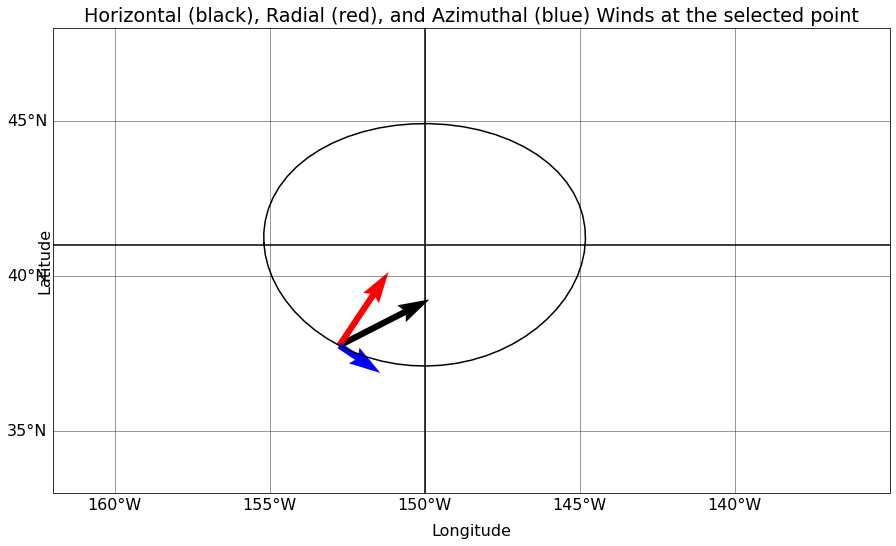

In [10]:
# This figure demonstrates how a wind on lat/lon coordinates at the selected point was transformed to radial and azimuthal components
fig = plt.figure(figsize=(15,15)) # create a figure
plt.rcParams.update({'font.size':16}) # change the font size

projection = ccrs.PlateCarree() # specify axes and projection option (see Cartopy website for the full list of projection types)
ax = plt.axes(projection=projection) 
ax.set_extent([np.min(lon), np.max(lon), np.min(lat), np.max(lat)],crs=projection)

# plot the polar coordinate and radius circle
# note: the radius circle does not look like a perfect circle because the zonal distance per degree longitude changes with latitude
plot1 = ax.plot((lon[0],lon[-1]),(latctr,latctr),transform=projection,color='k')
plot2 = ax.plot((lonctr,lonctr),(lat[0],lat[-1]),transform=projection,color='k')
x_circ = -1*radius*np.cos(np.arange(0,(2*math.pi)+0.1,0.1))*10**3
y_circ = radius*np.sin(np.arange(0,2*math.pi+0.1,0.1))*10**3
lat_circ = y_circ*(360/(2*math.pi*a))+latctr
lon_circ = x_circ*(360/(2*math.pi*a*np.cos(lat_circ*math.pi/180)))+lonctr
plot3 = ax.plot(lon_circ,lat_circ,transform=projection,color='k')

# add grid ticks
lontick = np.arange(-160,-135,5) # define longitude ticks
lattick = np.arange(35,50,5) # define latitude ticks
grl=ax.gridlines(crs=projection,draw_labels=True,color='k',alpha=0.5)
grl.top_labels = False
grl.right_labels = False
grl.xlocator = mticker.FixedLocator(lontick)
grl.ylocator = mticker.FixedLocator(lattick)

# to add x and y labels, add texts (set_xlabel and set_ylabel do not seem to work when you use Cartopy)
ax.text(np.mean(lon),np.min(lat)-1,'Longitude',ha='center',va='top')
ax.text(np.min(lon),np.mean(lat),'Latitude',ha='right',va='center',rotation=90)

# add vectors
vscale = 15*np.mean((usfc[:]**2+vsfc[:]**2)**0.5) # scale parameter for the length of vectors
plot4 = ax.quiver(lon_pt,lat_pt,u_pt,v_pt,scale=vscale,transform=projection,color='k')
plot5 = ax.quiver(lon_pt,lat_pt,u_radial*C_radial[0],u_radial*C_radial[1],scale=vscale,transform=projection,color='r')
plot6 = ax.quiver(lon_pt,lat_pt,u_azimuth*C_azimuth[0],u_azimuth*C_azimuth[1],scale=vscale,transform=projection,color='b')

# add title
ax.set_title('Horizontal (black), Radial (red), and Azimuthal (blue) Winds at the selected point') 